# DEM coregistration and glacier geodetic mass balance with xdem

### This notebook showcases how to use xdem to coregister two DEMs and calculate the glacier geodetic mass balance of Mera glacier, Nepal, using two DEMs derived from Pleiades stereo images.



### Import the necessary modules

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib widget

import geoutils as gu
import xdem

# To avoid interpolation in plt.imshow
plt.rcParams['image.interpolation'] = 'none'

## 1 - Load input data

All the data is taken from the Mera mass balance geodetic tutorial located in the "04_mb_Mera" folder.

#### Get input data path ###
### <span style='color:red '> **TO DO:** </span> If needed, update the path to the files below.


In [2]:
fn_dem_2012 = "../data/04_mb_Mera/rasters/Mera_Pleiades_2012-11-25_DEM_4m.tif"
fn_dem_2018 = "../data/04_mb_Mera/rasters/Mera_Pleiades_2018-10-28_DEM_4m.tif"
fn_ref_dem = "../data/04_mb_Mera/rasters/Mera_COP30_DEM_UTM45_data.tif"
rgi_shpfile = "../data/04_mb_Mera/RGI_shapefiles/Glacier_inventory_around_Mera.shp"
mera_shpfile_2012 = "../data/04_mb_Mera/glacier_outlines/Mera_outline_2012_realigned.shp"
mera_shpfile_2018 = "../data/04_mb_Mera/glacier_outlines/Mera_outline_2018_realigned.shp"

#### Load all DEMs at once, cropping to the common extent, and reprojecting onto the 2018 DEM grid

In [3]:
dem_2012, dem_2018, ref_dem = gu.raster.load_multiple_rasters([fn_dem_2012, fn_dem_2018, fn_ref_dem], crop=True, ref_grid=1)

#### Load glacier outlines

In [4]:
rgi_outlines = gu.Vector(rgi_shpfile)
mera_outlines_2012 = gu.Vector(mera_shpfile_2012)
mera_outlines_2018 = gu.Vector(mera_shpfile_2018)

### Calculate and plot elevation change

In [5]:
dh = dem_2018 - dem_2012

#### Plot original dh map with glacier contours

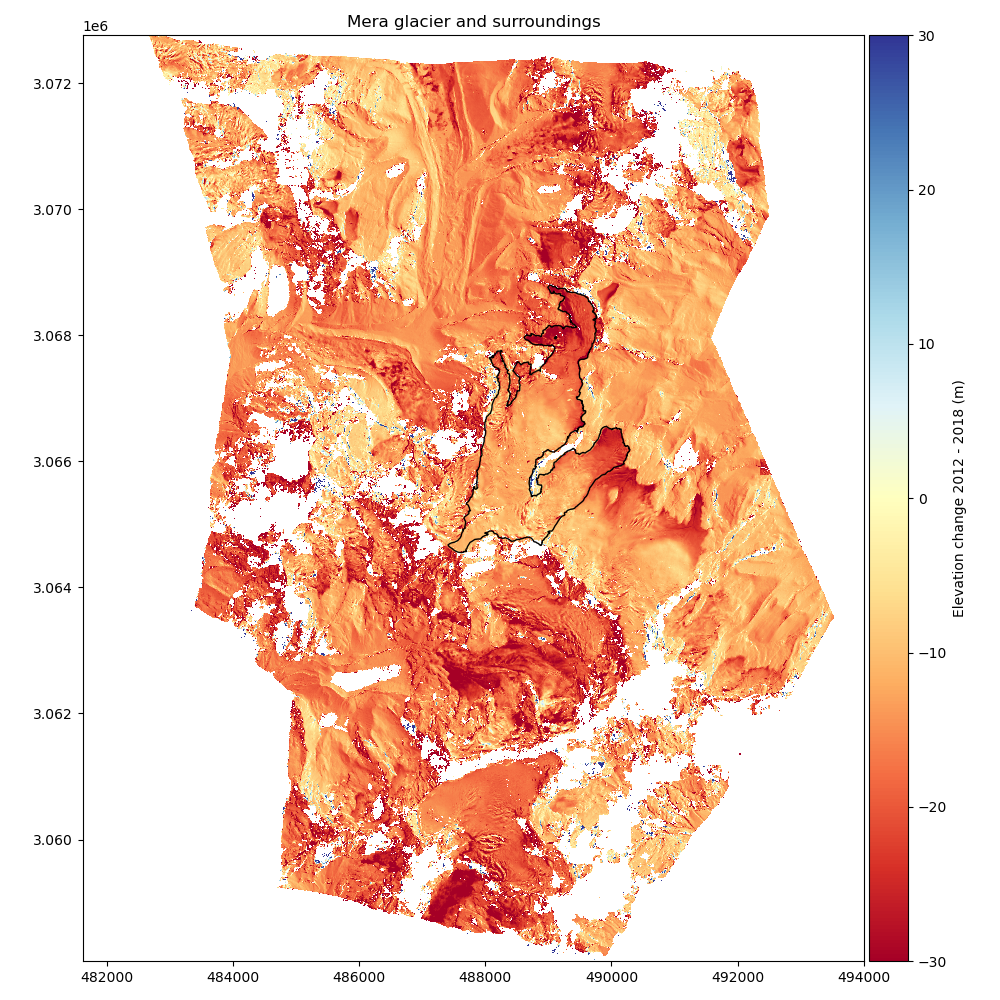

In [6]:
vmax=30
plt.figure(figsize=(10, 10))
ax = plt.subplot(111)
rgi_outlines.show(ax=ax, facecolor='none', edgecolor='k', lw=0.5, zorder=2)
mera_outlines_2012.show(ax=ax, facecolor='none', edgecolor='k', zorder=3)
dh.show(ax=ax, cmap='RdYlBu', vmin=-vmax, vmax=vmax, cbar_title='Elevation change 2012 - 2018 (m)', zorder=1)
ax.set_title('Mera glacier and surroundings')
plt.tight_layout()
plt.show()

There are non-zeros elevation changes outside of glaciers => These DEMs need to be coregistered.

## 2 - DEM coregistration

#### Prepare inputs for coregistration
First we create a mask, i.e. a raster of same shape as our dh map, to mask pixels on glaciers. `gl_mask` is `True` on glaciers, `False` elsewhere.

In [7]:
gl_mask = rgi_outlines.create_mask(dh)

Then we mask pixels in steep slopes and gross blunders

In [8]:
slope = xdem.terrain.slope(ref_dem)
slope_mask = (slope.data < 40).filled(False)
outlier_mask = (np.abs(dh.data) < 50).filled(False)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


We plot the final mask of pixels used for coregistration

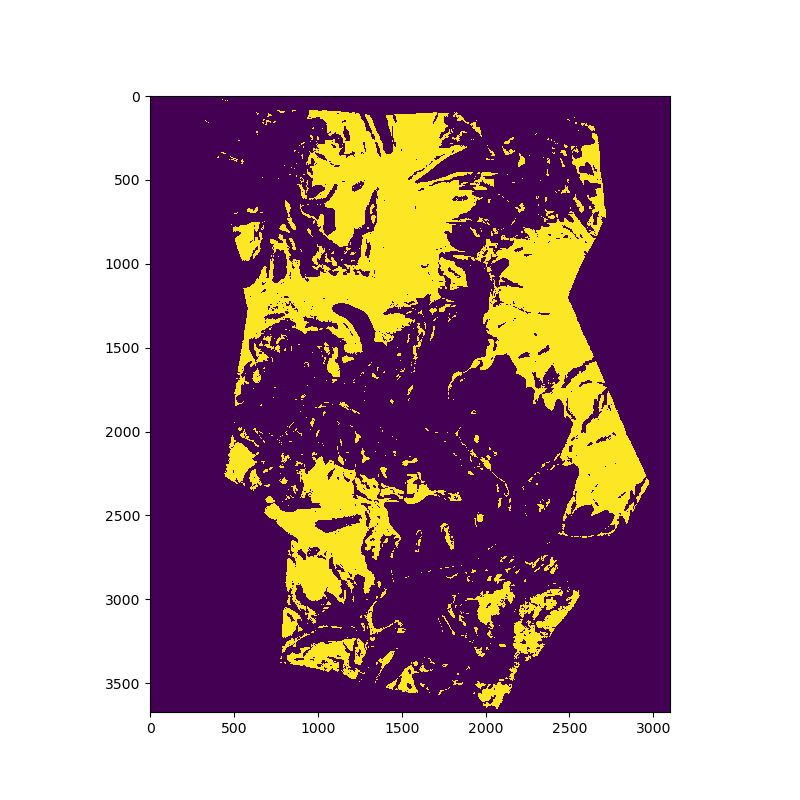

In [9]:
inlier_mask = ~gl_mask.data.data & slope_mask & outlier_mask
plt.figure(figsize=(8, 8))
plt.imshow(inlier_mask.squeeze())
plt.show()

Free memory (needed when running on binder)

In [10]:
del slope, slope_mask, outlier_mask

### Run coregistration
#### We use the Nuth & Kaab (2011) algorithm to estimate a horizontal offset, then we remove a possible vertical bias by removing the median dh value in stable terrain.

First, we need to define the coregistration function. \
Then we estimate the coregistration needed between our two Pleiades DEMs. \
Finally, we apply that coregistration to the 2012 DEM.

In [11]:
coreg = xdem.coreg.NuthKaab() + xdem.coreg.VerticalShift(vshift_func=np.median)
coreg.fit(dem_2018, dem_2012, inlier_mask, verbose=True)
dem_2012_coreg = coreg.apply(dem_2012)

Running pipeline step: 1 / 2
Running Nuth and Kääb (2011) coregistration
   Calculate slope and aspect
   Statistics on initial dh:
      Median = -13.51 - NMAD = 4.39
   Iteratively estimating horizontal shift:


   Progress:   0%|                                                                                                                                                                                                                                                                                     | 0/10 [00:00<?, ?it/s]

      #1 - Offset in pixels : (-2.11, -0.90)


   Progress:  10%|██████████████████████████▉                                                                                                                                                                                                                                                  | 1/10 [00:00<00:07,  1.22it/s]

      Median = -13.72 - NMAD = 0.70  ==>  Gain = -83.93%


   Progress:  10%|██████████████████████████▉                                                                                                                                                                                                                                                  | 1/10 [00:01<00:07,  1.22it/s]

      #2 - Offset in pixels : (-0.11, 0.07)


   Progress:  20%|█████████████████████████████████████████████████████▊                                                                                                                                                                                                                       | 2/10 [00:01<00:05,  1.41it/s]

      Median = -13.78 - NMAD = 0.69  ==>  Gain = -2.72%


   Progress:  20%|█████████████████████████████████████████████████████▊                                                                                                                                                                                                                       | 2/10 [00:01<00:05,  1.41it/s]

      #3 - Offset in pixels : (0.00, 0.00)


   Progress:  20%|█████████████████████████████████████████████████████▊                                                                                                                                                                                                                       | 2/10 [00:02<00:08,  1.04s/it]


      Median = -13.78 - NMAD = 0.69  ==>  Gain = 0.11%
   Last offset was below the residual offset threshold of 0.05 -> stopping

   Final offset in pixels (east, north) : (-2.219000, -0.819000)
   Statistics on coregistered dh:
      Median = -13.78 - NMAD = 0.69
Running pipeline step: 2 / 2
Estimating the vertical shift...
Vertical shift estimated


The results of the coregistration can be output like this

In [12]:
print(coreg.pipeline[0]._meta)

{'subsample': 500000.0, 'random_state': None, 'offset_east_px': -2.219, 'offset_north_px': -0.8190000000000001, 'vshift': -13.778474009764977, 'resolution': 4.0}


### <span style='color:red '> **Question:** </span> How many iterations of the Nuth & Kaab algorithm were run?


#### Answer: ...

### Calculate new elevation change and plot

In [14]:
dh_coreg = dem_2018 - dem_2012_coreg

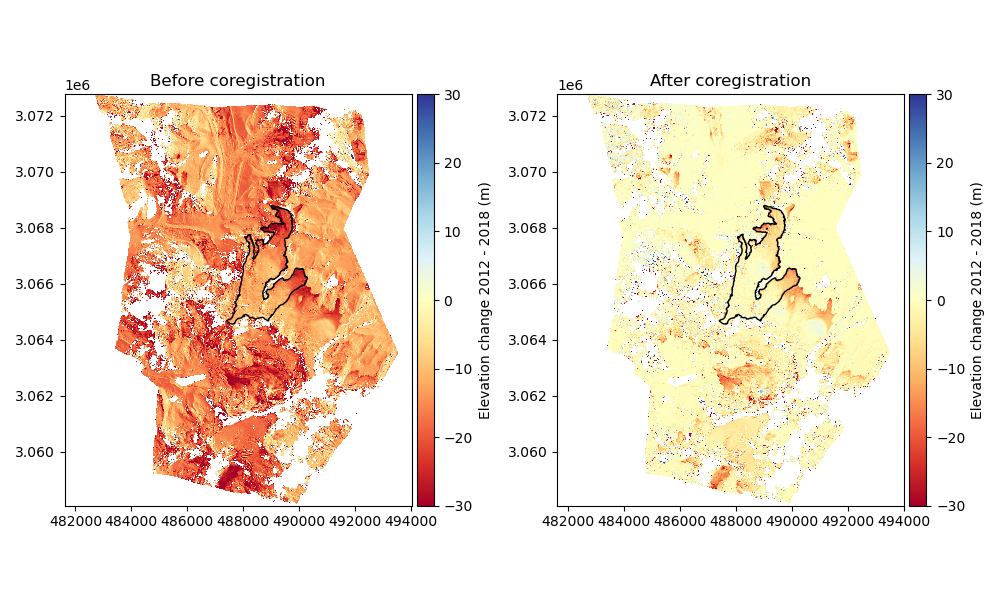

In [15]:
plt.figure(figsize=(10, 6))
ax1 = plt.subplot(121)
mera_outlines_2012.show(ax=ax1, facecolor='none', edgecolor='k', zorder=3)
dh.show(ax=ax1, cmap='RdYlBu', vmin=-vmax, vmax=vmax, cbar_title='Elevation change 2012 - 2018 (m)', zorder=1)
ax1.set_title('Before coregistration')

ax2 = plt.subplot(122)
mera_outlines_2012.show(ax=ax2, facecolor='none', edgecolor='k', zorder=3)
dh_coreg.show(ax=ax2, cmap='RdYlBu', vmin=-vmax, vmax=vmax, cbar_title='Elevation change 2012 - 2018 (m)', zorder=1)
ax2.set_title('After coregistration')

plt.tight_layout()
plt.show()

#### We see that elevation changes outside glaciers are close to zero (yellow color).

### Calculate statistics of before/after coregistration
Because `dh.data` is a masked array, we use `compressed()` to output only unmasked values.

In [16]:
inlier_orig = dh[inlier_mask]
nstable_orig, mean_orig = len(inlier_orig), np.mean(inlier_orig)
med_orig, nmad_orig = np.median(inlier_orig), xdem.spatialstats.nmad(inlier_orig)
print(f"Number of stable pixels: {nstable_orig}")
print(f"Before coregistration:\
      \n\tMean dh: {mean_orig:.2f}\
      \n\tMedian dh: {med_orig:.2f}\
      \n\tNMAD dh: {nmad_orig:.2f}")

inlier_coreg = dh_coreg[inlier_mask]
nstable_coreg, mean_coreg = len(inlier_coreg), np.mean(inlier_coreg)
med_coreg, nmad_coreg = np.median(inlier_coreg), xdem.spatialstats.nmad(inlier_coreg)
print(f"After coregistration:\
      \n\tMean dh: {mean_coreg:.2f}\
      \n\tMedian dh: {med_coreg:.2f}\
      \n\tNMAD dh: {nmad_coreg:.2f}")

Number of stable pixels: 2629453
Before coregistration:      
	Mean dh: -13.63      
	Median dh: -13.50      
	NMAD dh: 4.42
After coregistration:      
	Mean dh: -0.23      
	Median dh: 0.01      
	NMAD dh: 0.69


/usr/local/Caskroom/miniconda/base/envs/psf/lib/python3.10/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


## 3 - Geodetic mass balance of Mera glacier

### Calculate mean dh over glaciers, per elevation bins
We use the function `xdem.volume.hypsometric_binning` (see brief documentation [here](https://xdem.readthedocs.io/en/stable/gen_modules/xdem.volume.html)) to calculate the mean (or median) value of dh within elevation bands. \
The calculation requires a (raster) mask of the glacier, the dh values, and a reference DEM used to get the elevation of the pixels. All must be on the same grid. \
The default elevation bins have a height of 50 m, from the DEM minimum to maximum. Here we set the bin height to 25 m with the argument `bins`.

In [17]:
mera_mask = mera_outlines_2012.create_mask(dh_coreg)
ddem_bins = xdem.volume.hypsometric_binning(dh_coreg[mera_mask], ref_dem[mera_mask], bins=25, aggregation_function=np.median)

The output is a panda's DataFrame containing the elevation bin edges, the mean dh ('value') and observations (valid pixels) count.

In [18]:
print(ddem_bins)

                                          value    count
(4947.58642578125, 4972.58642578125]  -3.062012    179.0
(4972.58642578125, 4997.58642578125] -14.316162    284.0
(4997.58642578125, 5022.58642578125] -13.377441    591.0
(5022.58642578125, 5047.58642578125] -10.810059    891.0
(5047.58642578125, 5072.58642578125]  -8.211426    969.0
(5072.58642578125, 5097.58642578125] -10.762451   1540.0
(5097.58642578125, 5122.58642578125] -12.136719   1663.0
(5122.58642578125, 5147.58642578125] -10.615234   1415.0
(5147.58642578125, 5172.58642578125]  -9.230469   1183.0
(5172.58642578125, 5197.58642578125] -10.181641   1091.0
(5197.58642578125, 5222.58642578125] -10.265137   1069.0
(5222.58642578125, 5247.58642578125]  -8.834961   1419.0
(5247.58642578125, 5272.58642578125]  -8.572266   3106.0
(5272.58642578125, 5297.58642578125] -10.971191   6791.0
(5297.58642578125, 5322.58642578125] -10.683594   7447.0
(5322.58642578125, 5347.58642578125]  -8.937012   9839.0
(5347.58642578125, 5372.5864257

### Calculate the glacier area within each elevation bin
This is particularly needed for data with gaps, as the values in `ddem_bins['count']` are the number of pixels with observations, not total pixel count.
The result is in m$^2$.

In [19]:
bins_area = xdem.volume.calculate_hypsometry_area(ddem_bins, ref_dem[mera_mask], pixel_size=dh_coreg.res)
print(bins_area)

(4947.58642578125, 4972.58642578125]      2864.0
(4972.58642578125, 4997.58642578125]      4864.0
(4997.58642578125, 5022.58642578125]      9824.0
(5022.58642578125, 5047.58642578125]     14256.0
(5047.58642578125, 5072.58642578125]     15568.0
(5072.58642578125, 5097.58642578125]     25040.0
(5097.58642578125, 5122.58642578125]     26624.0
(5122.58642578125, 5147.58642578125]     22688.0
(5147.58642578125, 5172.58642578125]     19328.0
(5172.58642578125, 5197.58642578125]     18128.0
(5197.58642578125, 5222.58642578125]     17888.0
(5222.58642578125, 5247.58642578125]     23280.0
(5247.58642578125, 5272.58642578125]     50016.0
(5272.58642578125, 5297.58642578125]    109296.0
(5297.58642578125, 5322.58642578125]    120288.0
(5322.58642578125, 5347.58642578125]    159408.0
(5347.58642578125, 5372.58642578125]    252608.0
(5372.58642578125, 5397.58642578125]    292720.0
(5397.58642578125, 5422.58642578125]    153296.0
(5422.58642578125, 5447.58642578125]    120512.0
(5447.58642578125, 5

### <span style='color:red '> **Questions:** </span> 
- what is the median dh at 5400 m ?
- at which elevation is the highest thinning?
- what is the area of glaciers in the elevation band at 6000 m?


### Plot the results
1. Plot glacier area vs elevation
2. Plot the elevation change vs elevation

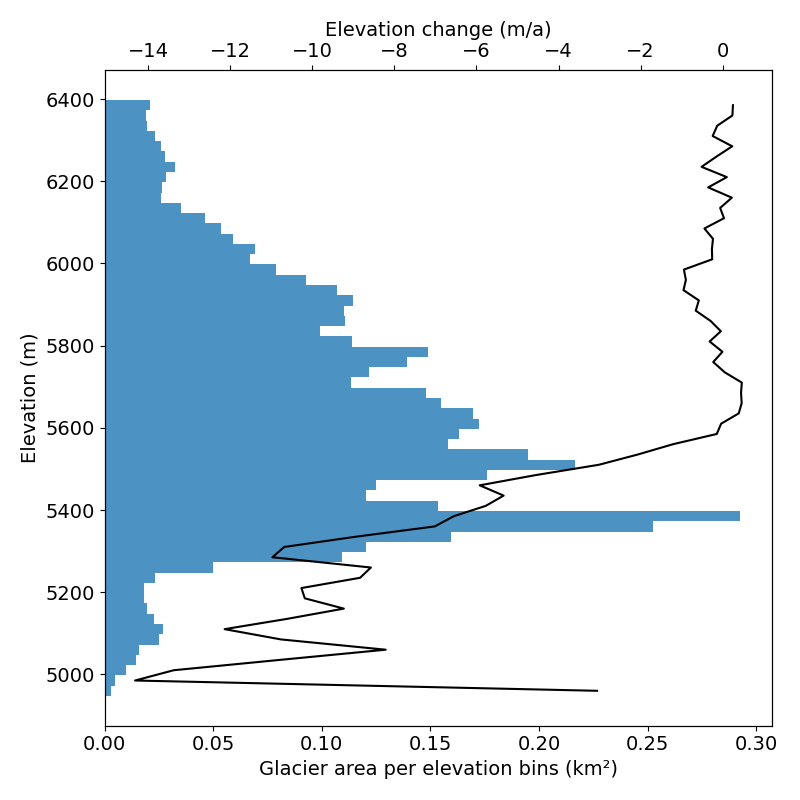

In [21]:
plt.rcParams['font.size'] = 14
plt.figure(figsize=(8, 8))

plt.barh(
    y=ddem_bins.index.mid,
    width=bins_area/1e6,
    left=0,
    height=(ddem_bins.index.left - ddem_bins.index.right) * 1,
    alpha=0.8,
)
plt.xlabel("Glacier area per elevation bins (km\u00b2)")
plt.ylabel("Elevation (m)")

plt.twiny()
plt.plot(ddem_bins["value"].values, ddem_bins.index.mid.values, "k")
plt.xlabel("Elevation change (m/a)")

plt.tight_layout()
plt.show()

The glacier area is plotted with blue bars (x axis at the bottom) and elevation change in dark line (x axis at the top) versus elevation (y axis).

### Calculate total volume and mass change
- volume change is in m$^3$
- volume is converted to mass (kg) assuming a volume to mass conversion factor of 850 kg/m$^3$ (Huss, 2013, TC)

In [22]:
dV = np.sum(ddem_bins['value'] * bins_area)  # in m^3
dM = 0.85 * dV  # in kg

### Calculate specific mass balance
In meter water equivalent (m w.e.)
We divide by the average area between the two dates.

In [23]:
mean_area = float((mera_outlines_2012.ds.Area + mera_outlines_2018.ds.Area) / 2)
dh_mwe = dM / mean_area

/var/folders/j9/8zcsp2m57n955fnkj13svrxh0000gn/T/ipykernel_9426/1006807018.py:1: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  mean_area = float((mera_outlines_2012.ds.Area + mera_outlines_2018.ds.Area) / 2)


### Print results

In [ ]:
print(f"Total volume change: {dV:.2f} m\u00b3")
print(f"Total mass change: {dM/1e3:.2f} t")
print(f"Specific mass balance: {dh_mwe:.1f} m w.e.")

## It's your turn !

Test running the code with other parameters, here are some ideas:
1. Calculate the mass balance using the mean value of each bin instead of the median.
2. Try with different elevation bin sizes
3. Try removing pixels whose value differ by more than five NMAD from the mean\
How sensitive are your results to these different parameters?\
Can your reproduce the results of Wagnon et al. (2021), JoG. Check the methods to see what bin size and filtering method they used. Your results should match their +/- 0.03 m w.e..
4. Try calculating the mass balance for another glacier.\
Hint 1: To select one glacier from the RGI outlines, use `rgi_outlines.ds[rgi_outlines.ds.RGIId == "YOUR_RGI_ID"]` where YOUR_RGI_ID is replaced by the ID of your chosen glacier, within the Pleiades DEM bounds.